Felipe Marinho Tavares RA 265680

# Brain MRI classification using SVM

Nesta atividade o objetivo é classificar imagens de ressonância magnética do cérebro em imagens com tumor (*tumor*) e imagens sem tumor (*health*). Para simplificar a tarefa, as imagens já foram processadas e, ao invés de serem fornecidas como imagens volumétricas (3D) em formato DICOM, elas estão sendo fornecidas como fatias (imagens 2D) e no formato jpg.

O classificador a ser utilizado para a tarefa é o SVM (suport vector machine) e deverá ser usado o *pipeline* de classificação tradicional, ou seja, as imagens precisam ser processadas e os atributos devem ser extraídos, para serem depois usados no treinamento do SVM.

Este notebook mostra como se faz para carregar as imagens, extrair alguns atributos simples, treinar o SVM e visualizar os resultados. O atributo escolhido, histograma do LBP, apesar de apresentar uma acurácia aceitável, apresenta uma especificidade muito baixa. Você verá que há linhas comentadas ao longo do código, deixadas de propósito como exemplo de formas alternativas de tratar os dados.

Você deve tentar alterar o notebook, focando no processamento das imagens, escolha e extração de atributos, com o objetivo de melhorar a classificação das imagens.

In [31]:
# Imports

import numpy as np
import random
import matplotlib.pyplot as plt
import time
import os
import glob
import copy
from PIL import Image

# connect drive
from google.colab import drive
drive.mount('/content/gdrive')

!ls 'gdrive/MyDrive/Brain_Tumor_Classification_Dataset/'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
test  train  val


## **Parte 1 - Carregando os dados (imagens e rótulos)**

Quando tentamos resolver um problema de classificação e vamos treinar um algoritmo supervisionado, precisamos de 3 conjuntos de dados: **treino**, **validação** e **teste**: 

- O conjunto de **treino** é o que será apresentado ao algoritmo, junto com o gabarito (rótulo, label, ground-thruth), e o algoritmo tentará aprender os padrões que separam as classes. 
- O conjunto de **validação** serve para testar se o algoritmo aprendeu, da seguinte forma: o modelo irá tentar predizer a saída e comparar com o rótulo daquela imagem de validação. Baseado nos erros e acertos no conjunto de validação, o algoritmo tenta ajustar seu modelo e predizer novamente. 
- O conjunto de **teste** só deve ser usado depois que o algoritmo já ajustou o modelo, para dar uma medida final de desempenho (acerto) do seu algoritmo.

Neste exemplo, para facilitar o trabalho de todos e garantir a comparação entre os resultados, os dados já estão organizados em 3 pastas: treino, validação e teste. Cada pasta contém as imagens e o rótulo de cada imagem (label). Lembrando que os dois rótulos possíveis são: *tumor* e *health*.

In [32]:
# Criação dos 3 subconjuntos de dados: train, val e test
# Dicionario de nome dataset com 3 grupos que contêm tanto images de sujeitos saudáveis quanto de pacientes com tumor.

data_dir = 'gdrive/MyDrive/Brain_Tumor_Classification_Dataset/'

subsets = ['train', 'val', 'test']
labels = ['tumor', 'health']

dataset = {
    "train": [],
    "val": [],
    "test": [],
}

for subset in subsets:
  for label in labels:
    print('loading ... ', subset, label, ' ...')
    file_list = glob.glob(data_dir + subset + '/' + label + '/*')

    for file in file_list:
      image = Image.open(file)
      # print(file, image.format, image.size, image.mode)
      # image = image - np.min(image) #normalização
      # image = (image/np.max(image)) #normalização
      dataset[subset].append((image, label))

    print('randomizing subgroup')
    random.shuffle(dataset[subset])

loading ...  train tumor  ...
randomizing subgroup
loading ...  train health  ...
randomizing subgroup
loading ...  val tumor  ...
randomizing subgroup
loading ...  val health  ...
randomizing subgroup
loading ...  test tumor  ...
randomizing subgroup
loading ...  test health  ...
randomizing subgroup


In [33]:
# Imprimindo informações sobre os dados

groups_len = {
    "train": [],
    "val": [],
    "test": [],
}

for subset in subsets:
  print(subset)
  subset_size = len(dataset[subset])
  subset_health_size = len([x for x in range(len(dataset[subset])) if dataset[subset][x][1] == 'health'])
  subset_tumor_size = subset_size - subset_health_size
  print('subgroug size = ', subset_size)
  groups_len[subset] = [subset_size, subset_health_size, subset_tumor_size]
  print('health subgroug size = ', subset_health_size, ' - ', (subset_health_size/subset_size)*100, '%')
  print('tumor subgroug size = ', subset_tumor_size, ' - ', (subset_tumor_size/subset_size)*100, '%')


train
subgroug size =  176
health subgroug size =  69  -  39.20454545454545 %
tumor subgroug size =  107  -  60.79545454545454 %
val
subgroug size =  51
health subgroug size =  19  -  37.254901960784316 %
tumor subgroug size =  32  -  62.745098039215684 %
test
subgroug size =  26
health subgroug size =  10  -  38.46153846153847 %
tumor subgroug size =  16  -  61.53846153846154 %


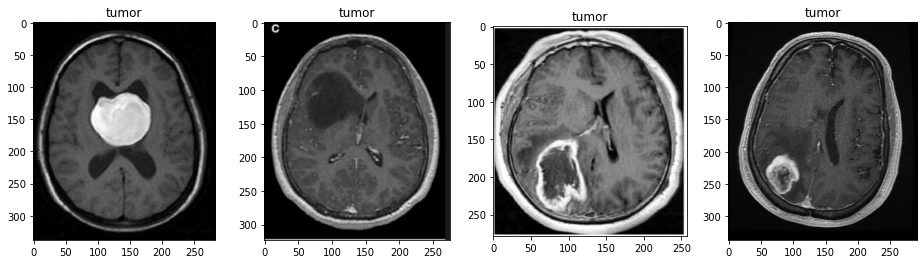

In [34]:
# Visualizando algumas imagens

def adjust_dimension(img): # algumas imagens possuem apenas 1 canal e algumas possuem 3. Essa função faz todas terem apenas 1 canal.
    if len(np.array(img).shape) > 2:
      return np.average(np.array(img), axis=2)
    else:
      return np.array(img)

# imagens de exemplo
plt.figure(figsize=(16, 4))
for i in range(4):
  plt.subplot(1, 4, i+1)
  plt.imshow(adjust_dimension(dataset['val'][i][0]),cmap='gray')
  plt.title(dataset['val'][i][1])
plt.show()

##**Parte 2 - Extraindo atributos (features)**

Como vimos no vídeo sobre atributos extraídos de imagens, a escolha dos atributos a serem utilizados depende do domínio e do problema a ser resolvido. O que vocês devem pensar é: "quais os atributos devem ter a capacidade de discriminar imagens com e sem tumor"? Abaixo há alguns exemplos de atributos que foram citados em aula, mas você pode decidir extrair outros atributos para resolver melhor o problema.


**1. Histograma de intensidades**

A função utilizada para extrair o histograma é a função **histogram** da biblioteca **Numpy**. Veja que ela tem alguns parâmetros que podem ser alterados, como por exemplo, o número de *bins*. Consulte a documentação desta função para ver diferentes formas de utilizá-la. Lembre-se também que o histograma puro não costuma ser usado como atributo, mas sim seus momentos (variância, moda, mediana, *skewness*, *kurtosis*, etc). Estes atributos podem ser extraídos usando-se funções da biblioteca Scipy.

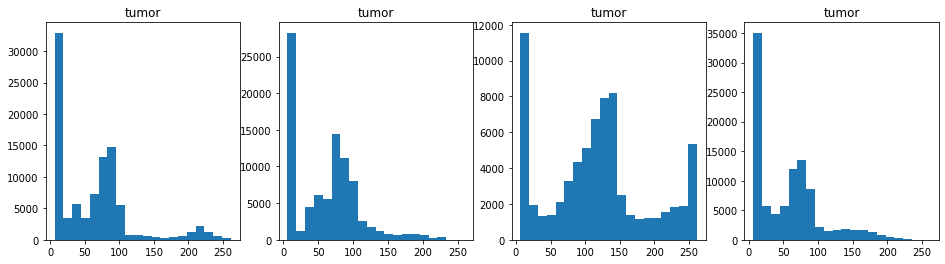

In [35]:
# histograma das imagens de exemplo
bins = 20
plt.figure(figsize=(16, 4))
for i in range(4):
  img = adjust_dimension(dataset['val'][i][0])
  height, x = np.histogram(img, bins=bins)
  plt.subplot(1, 4, i+1)
  plt.bar(x[1::], height, width=np.max(img)/bins)
  plt.title(dataset['val'][i][1])
plt.show()

**2. Local binary pattern (LBP)**

Assim como a função **histogram** a função **local_binary_pattern** tem alguns parâmetros que podem ser alterados: raio, método, número de pontos). Consultem a documentação da bibioteca skimage para mais detalhes. Além disso, lembrem-se que normalmente o LBP não é usado como atributo, mas sim seu histograma.

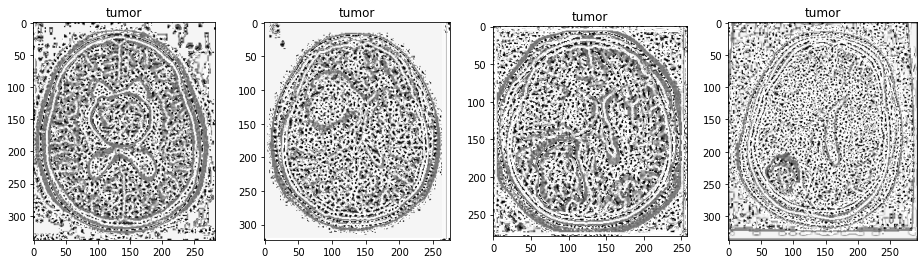

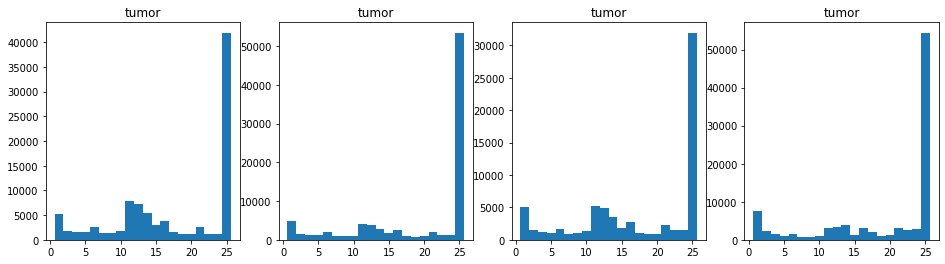

In [37]:
# Exemplo de um extrator de atributos de textura - LBP
from skimage.feature import local_binary_pattern

METHOD = 'uniform'
radius = 3
# radius = 8
n_points = 8 * radius

plt.figure(figsize=(16, 4))
for i in range(4):
  img = adjust_dimension(dataset['val'][i][0])
  lbp = local_binary_pattern(img, n_points, radius, METHOD)
  plt.subplot(1, 4, i+1)
  plt.imshow(lbp, 'gray')
  plt.title(dataset['val'][i][1])
plt.show()


# histograma do LBP

def lbp_histogram(img, bins = 10):
    lbp = local_binary_pattern(img, n_points, radius, METHOD)
    return np.histogram(lbp, bins=bins)

plt.figure(figsize=(16, 4))
for i in range(4):
  height, x = lbp_histogram(adjust_dimension(dataset['val'][i][0]), bins=bins)
  plt.subplot(1, 4, i+1)
  plt.bar(x[1::], height, width=np.max(lbp)/bins)
  plt.title(dataset['val'][i][1])
plt.show()

**3. Extraindo os atributos escolhidos dos 3 conjuntos de dados**

O código abaixo extrai todos os atributos selecionados para todos os conjuntos de dados e os coloca na forma de uma tabela de atributos. É importante lembrar que tudo o que for feito em termos de processamento e extração de features deve ser feito da mesma forma nos conjuntos de *treino*, *validação* e *teste*.

In [38]:
# Montagem das matrizes de atributos. 
# As matrizes são listas compostas por arrays (numéricos). Cada linha da lista representa uma amostra (imagem) e cada coluna do array representa um atributo.

# Extraindo os atributos para o conjunto de treino
print('extracting features train ...')
train_labels = []
train_features = []

for candidate in dataset['train']:
  label = candidate[1]
  img = adjust_dimension(candidate[0])

  train_labels.append(label)

  # train_features.append([np.array(img).min(), np.array(img).mean(), np.array(img).max()])
  # train_features.append(np.histogram(img)[0])
  # train_features.append(np.append(np.histogram(img)[0], [np.array(img).min(), np.array(img).mean(), np.array(img).max()])) # concatenação do histograma com estatisticas
  # train_features.append(np.append(lbp_histogram(img, bins=bins)[0], [np.array(img).min(), np.array(img).mean(), np.array(img).max()]))
  train_features.append(lbp_histogram(img, bins=bins)[0])

# Extraindo os mesmos atributos, agora para o conjunto de validação
print('extracting features validation ...')
val_labels = []
val_features = []

for candidate in dataset['val']:
  label = candidate[1]
  img = adjust_dimension(candidate[0])

  val_labels.append(label)

  # val_features.append([np.array(img).min(), np.array(img).mean(), np.array(img).max()])
  # val_features.append(np.histogram(img)[0])
  # val_features.append(np.append(np.histogram(img)[0], [np.array(img).min(), np.array(img).mean(), np.array(img).max()])) # concatenação do histograma com estatisticas
  # val_features.append(np.append(lbp_histogram(img, bins=bins)[0], [np.array(img).min(), np.array(img).mean(), np.array(img).max()]))
  val_features.append(lbp_histogram(img, bins=bins)[0])

# Extraindo os mesmos atributos para o conjunto de teste
print('extracting features test ...')
test_labels = []
test_features = []

for candidate in dataset['test']:
  label = candidate[1]
  img = adjust_dimension(candidate[0])

  test_labels.append(label)
  
  # test_features.append([np.array(img).min(), np.array(img).mean(), np.array(img).max()])
  # test_features.append(np.histogram(img)[0])
  # test_features.append(np.append(np.histogram(img)[0], [np.array(img).min(), np.array(img).mean(), np.array(img).max()])) # concatenação do histograma com estatisticas
  # test_features.append(np.append(lbp_histogram(img, bins=bins)[0], [np.array(img).min(), np.array(img).mean(), np.array(img).max()]))
  test_features.append(lbp_histogram(img, bins=bins)[0])
    
print('exemplo do label de uma imagem de treino = \n', train_labels[0])    
print('exemplo de atributos de uma imagem de treino = \n', train_features[0])

print('exemplo do label de uma imagem de validação = \n', val_labels[0])    
print('exemplo de atributos de uma imagem de validação = \n', val_features[0])

extracting features train ...
extracting features validation ...
extracting features test ...
exemplo do label de uma imagem de treino = 
 health
exemplo de atributos de uma imagem de treino = 
 [ 3249  1276  1188   998  1696  1002  1391  1878  8030  7441  4893  2542
  2608   814   648   670  1632   928   879 46213]
exemplo do label de uma imagem de validação = 
 tumor
exemplo de atributos de uma imagem de validação = 
 [ 5285  1741  1614  1544  2514  1323  1427  1796  7863  7338  5495  3023
  3856  1569  1196  1221  2546  1273  1123 41907]


##**Parte 3 - Treinando o algoritmo para classificar as imagens**

Uma vez de posse de umamatriz de atributos, podemos treinar qualquer classificador supervisionado. Neste exemplo escolhi usar o SVM, que costuma ter um bom desempenho e tem uma função fácil de usar na biblioteca **scikit learn**. É possível trocar o tipo de kernel do SVM (linear, polinomial, RBF), o número de iterações, etc. Consulte a documentação da bilbioteca para maiores informações.

In [39]:
# treinamento do classificador

from sklearn import svm
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

clf = svm.LinearSVC(max_iter=30)
# clf = svm.SVC(decision_function_shape='ovo')
# clf = make_pipeline(StandardScaler(),SGDClassifier(max_iter=1000, tol=1e-3))
clf.fit(train_features, train_labels)



/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=30,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

**1. Usando o classificador treinado para predizer uma amostra do conjunto de validação. Esta etapa pode ser repetida diversas vezes, como forma de escolher os hiperparâmetros do modelo de classificação

In [40]:
# Predição das amostras de validação com o classificador treinado

print('\n Conjunto de Validação \n')
val_preds = clf.predict(val_features)
CM_val = confusion_matrix(val_labels, val_preds)
Sensibilidade = CM_val[1,1]/groups_len['val'][2] # Sensibilidade: é a razão entre as imagens com tumor classificadas corretamente e o total de imagens com tumor (Verdadeiros positivos ÷ tumores)
Especificidade = CM_val[0,0]/groups_len['val'][1] # Especificidade: é a razão entre as imagens sem tumor classificadas corretamente e o total de imagens sem tumor (Verdadeiros negativos ÷ sadios)
print('labels = ', val_labels)
print('predições = ', val_preds)
print('matriz de confusão = \n', CM_val)
print('Sensibilidade = ', Sensibilidade)
print('Especificidade = ', Especificidade)
print('acc = ', np.sum(val_labels == val_preds)/val_preds.size)



 Conjunto de Validação 

labels =  ['tumor', 'tumor', 'tumor', 'tumor', 'health', 'tumor', 'tumor', 'health', 'health', 'tumor', 'health', 'tumor', 'tumor', 'health', 'tumor', 'tumor', 'tumor', 'tumor', 'health', 'tumor', 'tumor', 'tumor', 'tumor', 'health', 'tumor', 'health', 'health', 'health', 'tumor', 'health', 'tumor', 'health', 'health', 'health', 'tumor', 'tumor', 'health', 'tumor', 'tumor', 'tumor', 'health', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'health', 'tumor', 'tumor', 'health', 'health']
predições =  ['tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'health'
 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor'
 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor'
 'tumor' 'tumor' 'tumor' 'tumor' 'health' 'tumor' 'tumor' 'tumor' 'tumor'
 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor'
 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor']
matriz de confusão = 
 [[ 2 17]
 [ 0 32]]
Sensibilidade

In [ ]:
# Predição das amostras de teste com o classificador treinado
# Esta etapa só deve ser feita uma única vez, depois que os atributos foram escolhidos e o modelo final foi treinado. 

print('\n Conjunto de Teste \n')
test_preds = clf.predict(test_features)
CM_test = confusion_matrix(test_labels, test_preds)
Sensibilidade = CM_test[1,1]/groups_len['test'][2] # Sensibilidade: é a razão entre as imagens com tumor classificadas corretamente e o total de imagens com tumor (Verdadeiros positivos ÷ tumores)
Especificidade = CM_test[0,0]/groups_len['test'][1] # Especificidade: é a razão entre as imagens sem tumor classificadas corretamente e o total de imagens sem tumor (Verdadeiros negativos ÷ sadios)
print('labels = ', test_labels)
print('predições = ', test_preds)
print('matriz de confusão = \n', CM_test)
print('Sensibilidade = ', Sensibilidade)
print('Especificidade = ', Especificidade)
print('acc = ', np.sum(test_labels == test_preds)/test_preds.size)

Local Binary Pattern for texture classification:

https://scikit-image.org/docs/dev/auto_examples/features_detection/plot_local_binary_pattern.html?highlight=histogram


GLCM Texture Features: 

https://scikit-image.org/docs/dev/auto_examples/features_detection/plot_glcm.html

numpy.histogram:

https://numpy.org/doc/stable/reference/generated/numpy.histogram.html

SVM sklearn:

https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

sklearn.metrics:

https://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics